<a href="https://colab.research.google.com/github/jasim-1863/SDCProjects/blob/main/randomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random Forest Accuracy: 0.9300
Confusion Matrix:
[[106   6]
 [  8  80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       112
           1       0.93      0.91      0.92        88

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



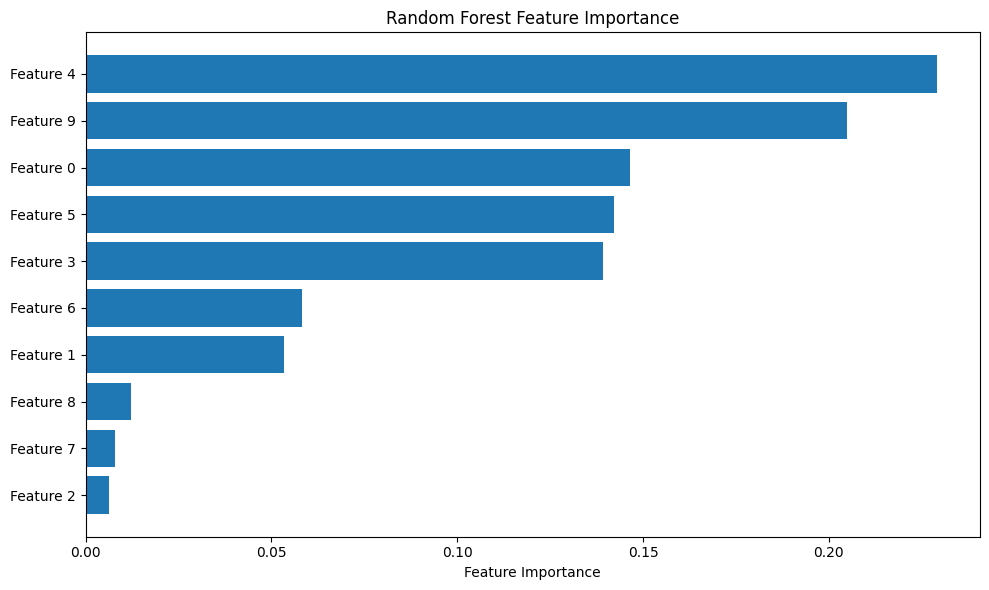


Cross-validation scores: [0.89  0.945 0.915 0.92  0.885]
Mean CV score: 0.9110

Simple Decision Tree Sample Predictions: [0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0]
Actual Values: [0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pandas as pd

# Generate sample data
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                           n_redundant=2, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = rf_model.feature_importances_
feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Cross validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# Simplified manual implementation of a Decision Tree (component of Random Forest)
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature    # Index of feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left      # Left subtree
        self.right = right    # Right subtree
        self.value = value    # Leaf node value (class label)

class SimpleDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        # Count classes in current node
        num_parent = [np.sum(y == c) for c in range(np.max(y) + 1)]

        # If pure node, return no split
        if np.max(num_parent) == m:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None

        # For each feature
        for idx in range(n):
            # Sort feature values and corresponding labels
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            # Consider each point between consecutive feature values as a threshold
            for i in range(1, m):
                # Skip if values are identical
                if thresholds[i] == thresholds[i - 1]:
                    continue

                thr = (thresholds[i] + thresholds[i - 1]) / 2

                # Labels for left (<=) and right (>) sides
                left_indices = X[:, idx] <= thr
                right_indices = ~left_indices

                # Skip if split doesn't divide the dataset
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                # Compute Gini impurity for left and right children
                left_y = y[left_indices]
                right_y = y[right_indices]

                gini_left = 1.0 - sum((np.sum(left_y == c) / len(left_y))**2 for c in range(np.max(y) + 1) if np.sum(left_y == c) > 0)
                gini_right = 1.0 - sum((np.sum(right_y == c) / len(right_y))**2 for c in range(np.max(y) + 1) if np.sum(right_y == c) > 0)

                # Weighted average of Gini impurity
                gini = (len(left_y) * gini_left + len(right_y) * gini_right) / m

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        m, n = X.shape

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or m <= 1:
            # Leaf node: return the most common class
            leaf_value = np.argmax([np.sum(y == c) for c in range(np.max(y) + 1)])
            return Node(value=leaf_value)

        # Find best split
        feature_idx, threshold = self._best_split(X, y)

        # If no improvement, make a leaf node
        if feature_idx is None:
            leaf_value = np.argmax([np.sum(y == c) for c in range(np.max(y) + 1)])
            return Node(value=leaf_value)

        # Split the dataset
        left_indices = X[:, feature_idx] <= threshold
        right_indices = ~left_indices

        # Build subtrees
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature_idx, threshold=threshold, left=left, right=right)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _predict_sample(self, x, node):
        # If leaf node, return the value
        if node.value is not None:
            return node.value

        # Navigate the tree
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

# Note: A full Random Forest implementation would involve creating multiple decision trees
# with bootstrap sampling and feature subsets, then aggregating their predictions.
# This is a simplified example for educational purposes.

# Test the simple decision tree on a small subset
simple_tree = SimpleDecisionTree(max_depth=3)
sample_X = X_train[:100]
sample_y = y_train[:100]
simple_tree.fit(sample_X, sample_y)
sample_predictions = simple_tree.predict(X_test[:20])
print("\nSimple Decision Tree Sample Predictions:", sample_predictions)
print("Actual Values:", y_test[:20])